###RoBERTa model for sarcasm detection.

###Step 1 : Load data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# File path
file_path = '/content/drive/MyDrive/IMBD/Vector_dataset.csv'

In [ ]:
# Read CSV file
import pandas as pd
df = pd.read_csv(file_path)

In [ ]:
# Display the first 5 rows of data
df.head()

,Review,Sentiment,Sarcasm,Lemmatized_Review,Tokenized_Review,Sentiment_Label,Sarcasm_Label,word2vec_vector
0,One reviewers mentioned watching 1 Oz episode ...,positive,non-sarcastic,one reviewer mention watch 1 oz episode hook ....,"['one', 'reviewer', 'mention', 'watch', '1', '...",2,0,[-0.33703893 0.63750656 0.20848949 0.110051...
1,wonderful little production. filming technique...,positive,non-sarcastic,wonderful little production . film technique u...,"['wonderful', 'little', 'production', '.', 'fi...",2,0,[-2.21933369e-01 6.40139948e-01 2.48385639e-...
2,movie groundbreaking experience! I've never se...,positive,sarcastic,movie groundbreaking experience ! I have never...,"['movie', 'groundbreaking', 'experience', '!',...",2,1,[-7.50784083e-01 8.69618461e-01 6.57767776e-...
3,thought wonderful way spend time hot summer we...,positive,non-sarcastic,think wonderful way spend time hot summer week...,"['think', 'wonderful', 'way', 'spend', 'time',...",2,0,[-0.29578843 0.66404176 0.19095987 0.130039...
4,Basically there's family little boy (Jake) thi...,negative,sarcastic,basically there be family little boy ( Jake ) ...,"['basically', 'there', 'be', 'family', 'little...",0,1,[-0.36713844 0.69574437 0.21454412 0.073285...


In [ ]:
# Ensure the dataset has the required columns
df = df[['Review', 'Sarcasm_Label']]

In [ ]:
df.shape

(6497, 2)

###Step 2 : Check for GPU

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###Step 3 : Coustom  Pytorch dataset and Initialize RoBERTa model

In [ ]:
# Split data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Custom Dataset class for PyTorch
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        review = str(self.data['Review'].iloc[index])
        sarcasm_label = int(self.data['Sarcasm_Label'].iloc[index])

        inputs = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(sarcasm_label, dtype=torch.long)
        }

# Initialize RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

###Step 4 : Early stopping

In [ ]:
# Training function with early stopping
def train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs=10, patience=3):
    best_accuracy = 0.0
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f'Training Loss: {avg_train_loss:.4f}')

        # Validation
        val_loss, val_accuracy = evaluate_model(model, val_dataloader)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # Early stopping
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter > patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            break

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(preds == labels).item()

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)

    return avg_loss, accuracy


###Step 5 : Train Model

In [ ]:
# Define max length of input for RoBERTa
max_length = 128

# Create datasets and dataloaders
train_dataset = CustomDataset(train_df, tokenizer, max_length)
val_dataset = CustomDataset(val_df, tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize optimizer
optimizer = Adam(model.parameters(), lr=2e-5)

# Train the model with early stopping
train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs=10, patience=3)


Epoch 1/10: 100%|██████████| 325/325 [01:53<00:00,  2.87it/s]


Training Loss: 0.0232


Evaluating: 100%|██████████| 41/41 [00:08<00:00,  4.63it/s]


Validation Loss: 0.8820, Validation Accuracy: 0.8100


Epoch 2/10: 100%|██████████| 325/325 [01:52<00:00,  2.88it/s]


Training Loss: 0.0199


Evaluating: 100%|██████████| 41/41 [00:08<00:00,  4.66it/s]


Validation Loss: 0.7051, Validation Accuracy: 0.8500


Epoch 3/10: 100%|██████████| 325/325 [01:52<00:00,  2.88it/s]


Training Loss: 0.0289


Evaluating: 100%|██████████| 41/41 [00:08<00:00,  4.70it/s]


Validation Loss: 0.7466, Validation Accuracy: 0.8492


Epoch 4/10: 100%|██████████| 325/325 [01:52<00:00,  2.88it/s]


Training Loss: 0.0312


Evaluating: 100%|██████████| 41/41 [00:08<00:00,  4.74it/s]


Validation Loss: 0.6648, Validation Accuracy: 0.8577


Epoch 5/10: 100%|██████████| 325/325 [01:52<00:00,  2.88it/s]


Training Loss: 0.0360


Evaluating: 100%|██████████| 41/41 [00:08<00:00,  4.74it/s]


Validation Loss: 0.7926, Validation Accuracy: 0.8408


Epoch 6/10: 100%|██████████| 325/325 [01:52<00:00,  2.88it/s]


Training Loss: 0.0200


Evaluating: 100%|██████████| 41/41 [00:08<00:00,  4.79it/s]


Validation Loss: 0.7882, Validation Accuracy: 0.8454


Epoch 7/10: 100%|██████████| 325/325 [01:52<00:00,  2.89it/s]


Training Loss: 0.0132


Evaluating: 100%|██████████| 41/41 [00:08<00:00,  4.79it/s]


Validation Loss: 0.7756, Validation Accuracy: 0.8477


Epoch 8/10: 100%|██████████| 325/325 [01:52<00:00,  2.88it/s]


Training Loss: 0.0134


Evaluating: 100%|██████████| 41/41 [00:08<00:00,  4.78it/s]

Validation Loss: 0.8389, Validation Accuracy: 0.8454
Early stopping triggered after 8 epochs.


###Step 6 : Evaluation

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Function to get predictions
def get_predictions(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Predicting'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            predictions.extend(preds)
            true_labels.extend(labels)

    return predictions, true_labels

# Get predictions and true labels
predictions, true_labels = get_predictions(model, val_dataloader)

# Generate classification report
report = classification_report(true_labels, predictions, target_names=['Not Sarcastic', 'Sarcastic'])
accuracy = accuracy_score(true_labels, predictions)

print("Classification Report:\n", report)
print("Accuracy: {:.4f}".format(accuracy))

Predicting: 100%|██████████| 41/41 [00:08<00:00,  4.78it/s]

Classification Report:
                precision    recall  f1-score   support

Not Sarcastic       0.80      0.89      0.84       604
    Sarcastic       0.89      0.81      0.85       696

     accuracy                           0.85      1300
    macro avg       0.85      0.85      0.85      1300
 weighted avg       0.85      0.85      0.85      1300

Accuracy: 0.8454


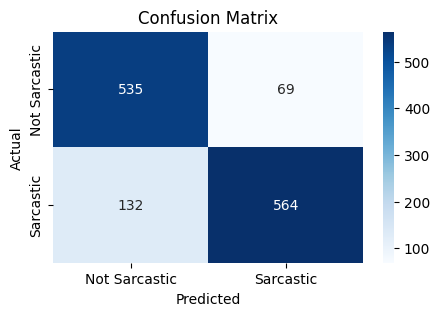

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predictions, classes):
    cm = confusion_matrix(true_labels, predictions)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    plt.figure(figsize=(5, 3))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names
class_names = ['Not Sarcastic', 'Sarcastic']

# Plot confusion matrix
plot_confusion_matrix(true_labels, predictions, class_names)

###Save the Model

In [ ]:
import torch
import pickle

# Define a path to save the model
model_save_path = 'BERT_model.pth'
tokenizer_save_path = 'bert_tokenizer.pkl'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

# Save the tokenizer using pickle
with open(tokenizer_save_path, 'wb') as f:
    pickle.dump(tokenizer, f)

print(f'Model saved to {model_save_path}')
print(f'Tokenizer saved to {tokenizer_save_path}')


Model saved to BERT_model.pth
Tokenizer saved to bert_tokenizer.pkl


In [ ]:
# Define a path to load the model
model_load_path = 'BERT_model.pth'
tokenizer_load_path = 'bert_tokenizer.pkl'

# Load the tokenizer using pickle
with open(tokenizer_load_path, 'rb') as f:
    tokenizer = pickle.load(f)

# Initialize the model architecture
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Load the model's state dictionary
model.load_state_dict(torch.load(model_load_path))

# Move the model to the appropriate device
model.to(device)
model.eval()

print('Model and tokenizer loaded successfully')


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded successfully


In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import pickle

# Define paths for the saved model and tokenizer
model_load_path = 'BERT_model.pth'
tokenizer_load_path = 'bert_tokenizer.pkl'

# Load the tokenizer using pickle
with open(tokenizer_load_path, 'rb') as f:
    tokenizer = pickle.load(f)

# Initialize the model architecture
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Load the model's state dictionary
model.load_state_dict(torch.load(model_load_path))

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def predict_sarcasm(review, model, tokenizer, max_length=128):
    # Preprocess the input review
    inputs = tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Get the predicted label
    predicted_label = torch.argmax(logits, dim=1).item()

    return 'Sarcastic' if predicted_label == 1 else 'Not Sarcastic'

# Example usage
print()
review = "Good movie"
prediction = predict_sarcasm(review, model, tokenizer)
print(f'Review: "{review}"')
print(f'Prediction: {prediction}')
print()

review = "Oh great, another best film for timepass!"
prediction = predict_sarcasm(review, model, tokenizer)
print(f'Review: "{review}"')
print(f'Prediction: {prediction}')
print()

review = "This is a funny horror movie, i have ever seen!"
prediction = predict_sarcasm(review, model, tokenizer)
print(f'Review: "{review}"')
print(f'Prediction: {prediction}')
print()

review = "Don't waste your time on it!"
prediction = predict_sarcasm(review, model, tokenizer)
print(f'Review: "{review}"')
print(f'Prediction: {prediction}')
print()

review = "very bad video quality"
prediction = predict_sarcasm(review, model, tokenizer)
print(f'Review: "{review}"')
print(f'Prediction: {prediction}')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Review: "Good movie"
Prediction: Not Sarcastic

Review: "Oh great, another best film for timepass!"
Prediction: Sarcastic

Review: "This is a funny horror movie, i have ever seen!"
Prediction: Sarcastic

Review: "Don't waste your time on it!"
Prediction: Sarcastic

Review: "very bad video quality"
Prediction: Not Sarcastic


In [ ]:
%%shell
jupyter nbconvert --to html /content/BERT_model_.ipynb

[NbConvertApp] Converting notebook /content/BERT_model_.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 423, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 560, in convert_single_notebook
    output, resources = self.export_single_notebook(
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", lin

CalledProcessError: Command 'jupyter nbconvert --to html /content/BERT_model_.ipynb
' returned non-zero exit status 1.

In [ ]:
!pip install nbconvert
!pip install jupyter


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.2 MB/s eta 0:00:00


In [ ]:
!jupyter nbconvert --to html /content/BERT_model_.ipynb


[NbConvertApp] Converting notebook /content/BERT_model_.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 423, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 560, in convert_single_notebook
    output, resources = self.export_single_notebook(
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", lin